# Add LLM Trustworthiness Scoring to any LangChain or LangGraph application, an example application for sustainability!
Original Artical credits: https://colab.research.google.com/github/cleanlab/cleanlab-studio-tutorials/blob/main/tlm-use-cases/tlm_langchain.ipynb

<head>
  <meta name="title" content="Add LLM Trustworthiness Scoring to any LangChain or LangGraph application"/>
  <meta property="og:title" content="Add LLM Trustworthiness Scoring to any LangChain or LangGraph application"/>
  <meta name="twitter:title" content="Add LLM Trustworthiness Scoring to any LangChain or LangGraph application" />
  <meta name="image" content="/img/langchain.png" />
  <meta property="og:image" content="/img/langchain.png" />
  <meta name="description" content="How to mitigate unchecked hallucination in your LangChain apps."  />
  <meta property="og:description" content="How to mitigate unchecked hallucination in your LangChain apps." />
  <meta name="twitter:description" content="How to mitigate unchecked hallucination in your LangChain apps." />
</head>

LLMs are prone to unchecked *hallucinations* where they occasionally produce plausible but incorrect responses.
The [Trustworthy Language Model](https://cleanlab.ai/blog/trustworthy-language-model/) (TLM) scores the trustworthiness of responses from *any* LLM using state-of-the-art model uncertainty estimation techniques.



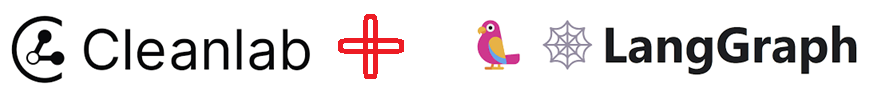

In [41]:

from IPython.display import Image
Image('./lang_graph_and_cleanlab.png')

## Setup

We need the LangChain, LangGraph, OpenAI, and Cleanlab Studio Python libraries for this tutorial.

In [15]:
%pip install -qU langchain_core langchain_openai langgraph cleanlab_studio

In [16]:
import os
import logging

from langchain_core.callbacks import BaseCallbackHandler
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

from cleanlab_studio import Studio

## Create a simple chain

This tutorial is based on [LangChain's chatbot tutorial](https://python.langchain.com/docs/how_to/chatbots_memory/). Start there if you aren't familiar with LangChain or LangGraph.

Let's create a simple conversational chain using standard concepts like: `prompt_template`, `graph`, `memory`, and `model`.

In [17]:
# Define prompt template with placeholder for messages
prompt_template = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant."),
        MessagesPlaceholder(variable_name="messages"),
    ])

In [18]:
# Define graph for managing state
workflow = StateGraph(state_schema=MessagesState)

# Function that calls the LLM given current state
def call_model(state: MessagesState):
    # Given the current state of messages, prompt the model
    response = model.invoke(state["messages"])
    return {"messages": response}

# Define single node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [19]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
CLEAN_LAB_API_KEY = userdata.get('CLEAN_LAB_API_KEY')

Next we instantiate the LLM object.

In [20]:
model = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)

# config ID to capture unique state
config = {"configurable": {"thread_id": "without-tlm"}}

The simple chain offers conversations with the LLM. Let’s ask an example question about lakes in California.

In [32]:
query_sustainability = "Which country has the least sustainable energy production in the world? Please just name the country and where it is located in a json format output."
input_messages = [HumanMessage(query_sustainability)]

output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

[TLM Score]: 0.4192591853348947 (Untrustworthy)
[TLM Score Explanation]: This response is untrustworthy due to lack of consistency in possible responses from the model. Here's one inconsistent alternate response that the model considered (which may not be accurate either): 
": {
    "country": "Kuwait",
    "location": "Middle East"
  }
}
```.
================================== Ai Message ==================================

```json
{
  "country": "Saudi Arabia",
  "location": "Middle East"
}
```


Being a stateful chain with memory, we can ask follow-up questions and the LLM will automatically refer back to previous messages as necessary.

In [33]:
query = "Explain your answer, what makes it least sustainable?"
input_messages = [HumanMessage(query)]

output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

[TLM Score]: 0.9392494996227913 (Trustworthy)
[TLM Score Explanation]: Did not find a reason to doubt trustworthiness.
================================== Ai Message ==================================

Saudi Arabia is often considered one of the countries with the least sustainable energy production due to several key factors:

### 1. **Heavy Reliance on Fossil Fuels**
   - Saudi Arabia's energy production is dominated by fossil fuels, particularly oil. The country is one of the world's largest oil producers and exporters, relying almost entirely on this single resource for its energy needs. This reliance on fossil fuels contributes significantly to carbon emissions and environmental degradation.

### 2. **High Carbon Emissions**
   - The combustion of oil and gas for energy leads to substantial greenhouse gas emissions. As fossil fuels are carbon-intensive, Saudi Arabia's energy sector has a high carbon footprint, contributing to climate change.

### 3. **Limited Use of Renewable Energ

So far the responses from the LLM looks good. Let's integrate trustworthiness scoring to this chain to see if there's a scope for hallucination.

## Add trustworthiness scoring

It's easy to integrate TLM's trustworthiness score in *any* existing chain, irrespective of the LLM model (streaming or batch, async or not).

We simply define a [Langchain callback](https://python.langchain.com/docs/concepts/callbacks/) that triggers whenever the LLM generates a response.
TLM considers both the prompt (with system, user, context messages) and the LLM response in its trustworthiness scoring.

Let's define this custom callback handler.

In [34]:
class TrustworthinessScoreCallback(BaseCallbackHandler):
    def __init__(self, tlm, threshold = 0.7, explanation = True):
        # Cleanlab's TLM client
        self.tlm = tlm
        # Keep track of the prompt
        self.prompt = ""
        # Threshold to trigger actions
        self.threshold = threshold
        # Boolean to enable/disable explanation
        self.explanation = explanation

    def on_llm_start(self, serialized, prompts, run_id, **kwargs):
        # Store input prompt
        self.prompt = prompts[0]

    def on_llm_end(self, response, **kwargs):
        # Extract response text from LLMResult object
        response_text = response.generations[0][0].text

        # Call trustworthiness score method, and extract the score
        resp = self.tlm.get_trustworthiness_score(self.prompt, response_text)
        score = resp['trustworthiness_score']

        # Log score
        # This can be replaced with any action that the application requires
        # We just print it along with its tag, trustworthy or otherwise
        if score < self.threshold:
            print(f"[TLM Score]: {score} (Untrustworthy)")
        else:
            print(f"[TLM Score]: {score} (Trustworthy)")

        # Log explanation
        # Reasoning for the predicted trustworthiness score
        if self.explanation and resp.get("log", {}).get("explanation"):
            print(f"[TLM Score Explanation]: {resp['log']['explanation']}")
        elif self.explanation:
            print("[TLM Warning]: Enable `explanation` in TLM client.")

We then instantiate the TLM object used by this callback. We specify `explanation` in TLM's `options` argument to obtain rationales for why LLM responses are deemed untrustworthy.

Note: You can get a free Cleanlab API key [here](https://app.cleanlab.ai/?signup_origin=TLM).

In [35]:
client = Studio(api_key=CLEAN_LAB_API_KEY)  # Get free API key from: https://app.cleanlab.ai/account after creating an account
tlm = client.TLM(options={'log':['explanation']})  # You can also omit explanations

Finally, we instantiate an instance of the callback with the TLM object. Currently, the callback would print the trustworthiness score and explanation, but you can modify what actions to take based on the trustworthiness score to meet your needs.
For instance, you might threshold the scores and revert to some fallback action whenever LLM responses are deemed untrustworthy

The callback is attached to the LLM so it triggers whenever the LLM is called in a chain.
You can attach the callback to multiple LLMs, agents, and other objects that generate a responses when given a prompt.

In [36]:
trustworthiness_callback = TrustworthinessScoreCallback(tlm, explanation=True)
model.callbacks = [trustworthiness_callback]

Now let's reset the memory of the assistant and ask the same questions, now with trustworthiness scoring enabled.

In [37]:
app = workflow.compile(checkpointer=MemorySaver())
config = {"configurable": {"thread_id": "with-tlm"}}

In [38]:
query = "Which country has the least sustainable energy production in the world? Please just name the country and where it is located in a json format output."
input_messages = [HumanMessage(query)]

output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

[TLM Score]: 0.2605516381820897 (Untrustworthy)
[TLM Score Explanation]: The question asks for a specific country that has the least sustainable energy production in the world, which implies a factual answer based on data regarding energy production and sustainability. The proposed answer identifies Burundi as the country with the least sustainable energy production and provides its location in East Africa. However, the accuracy of this claim can be debated, as sustainability metrics can vary based on different criteria and sources. While Burundi may have low levels of sustainable energy production, other countries may also be contenders for this title depending on the metrics used. Therefore, the question does have a well-defined factual answer, but the proposed answer may not be definitively correct without current and specific data to support it. Thus, the answer is not definitively correct or incorrect based on the information provided. 
This response is untrustworthy due to lack o

We see that the LLM hallucinated for this simple question. The low trustworthiness score from TLM helps you automatically catch such problems in real-time.

TLM optionally provides explanations for its trustworthiness score. You can disable explanations by setting `TrustworthinessScoreCallback(tlm, explanation=False)`.

Feel free to modify this callback to meet your application's needs. Mitgating unchecked hallucinations is a key step toward reliable AI applications!